# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)

In [1]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [4]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


Ticker,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2024-11-22,197.119995,47.000000,964.010010,115.650002,453.350006,63.438839,290.279999,417.000000,2.97,102.500000
2024-11-25,201.449997,47.500000,960.890015,116.000000,469.179993,63.895374,296.190002,418.790009,2.95,101.839996
2024-11-26,207.860001,47.750000,971.500000,115.449997,472.910004,64.064102,296.329987,427.989990,2.88,100.680000
2024-11-27,205.740005,47.770000,961.549988,117.599998,472.339996,63.945000,295.079987,422.989990,2.88,101.510002
2024-11-29,207.889999,47.509998,971.880005,117.470001,476.190002,64.080002,296.010010,423.459991,2.68,102.459999


In [5]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
1993-01-29,24.608627
1993-02-01,24.783642
1993-02-02,24.836149
1993-02-03,25.098694
1993-02-04,25.203718


In [6]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 3148374343680,
 'AMZN': 2185963372544,
 'NAT': 601333056,
 'BAC': 366533443584,
 'DPZ': 16443793408,
 'DIS': 212966064128,
 'KO': 277551644672,
 'MCD': 212126695424,
 'COST': 430614740992,
 'SBUX': 116169138176}

## Constructing the prior

In [7]:
import pypfopt
pypfopt.__version__

'1.5.6'

In [8]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

np.float64(3.401732529775816)

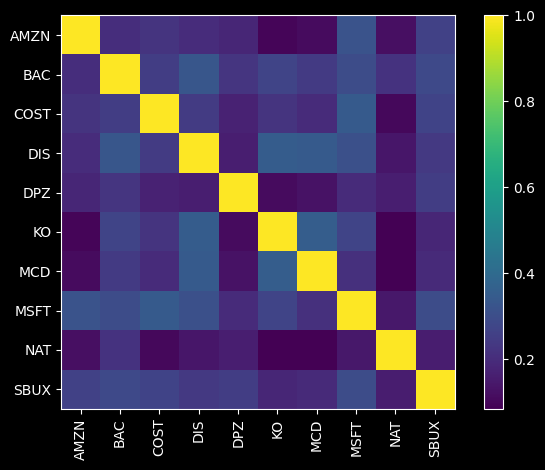

In [9]:
plotting.plot_covariance(S, plot_correlation=True);

In [10]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
AMZN    0.209014
BAC     0.104631
COST    0.078294
DIS     0.092434
DPZ     0.038470
KO      0.053045
MCD     0.058147
MSFT    0.156181
NAT     0.041635
SBUX    0.078083
dtype: float64

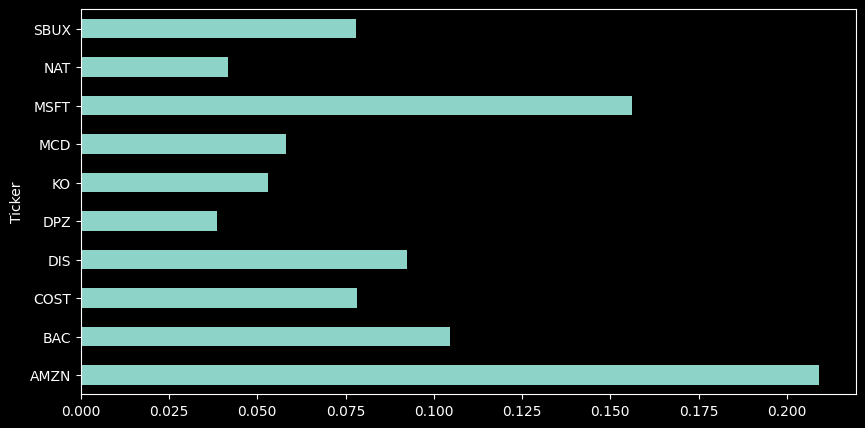

In [11]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [12]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [13]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [14]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

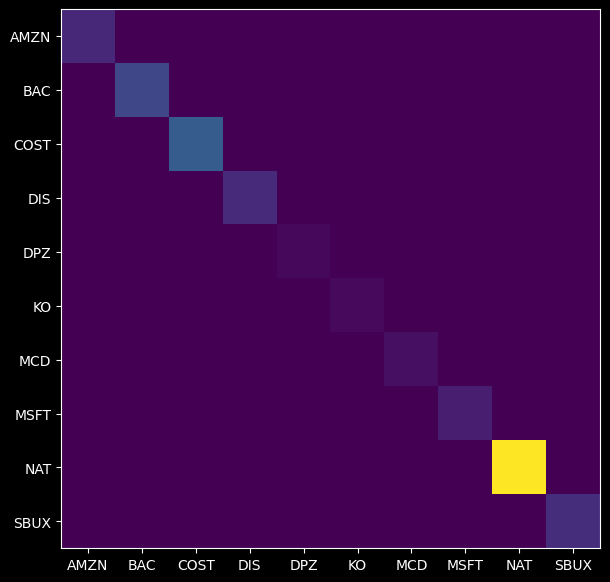

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [16]:
np.diag(bl.omega)

array([0.00456881, 0.00877776, 0.01202519, 0.00494424, 0.0008738 ,
       0.00112756, 0.00168424, 0.00344649, 0.04131355, 0.00547976])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [17]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [18]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [19]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [20]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
AMZN    0.178794
BAC     0.137065
COST    0.068768
DIS     0.074427
DPZ     0.107061
KO      0.008443
MCD     0.103680
MSFT    0.107061
NAT     0.063914
SBUX    0.086824
dtype: float64

We can visualise how this compares to the prior and our views:

In [21]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.209014,0.178794,0.10
BAC,0.104631,0.137065,0.30
COST,0.078294,0.068768,0.05
DIS,0.092434,0.074427,0.05
DPZ,0.038470,0.107061,0.20
KO,0.053045,0.008443,-0.05
MCD,0.058147,0.103680,0.15
MSFT,0.156181,0.107061,0.10
NAT,0.041635,0.063914,0.50
SBUX,0.078083,0.086824,0.10


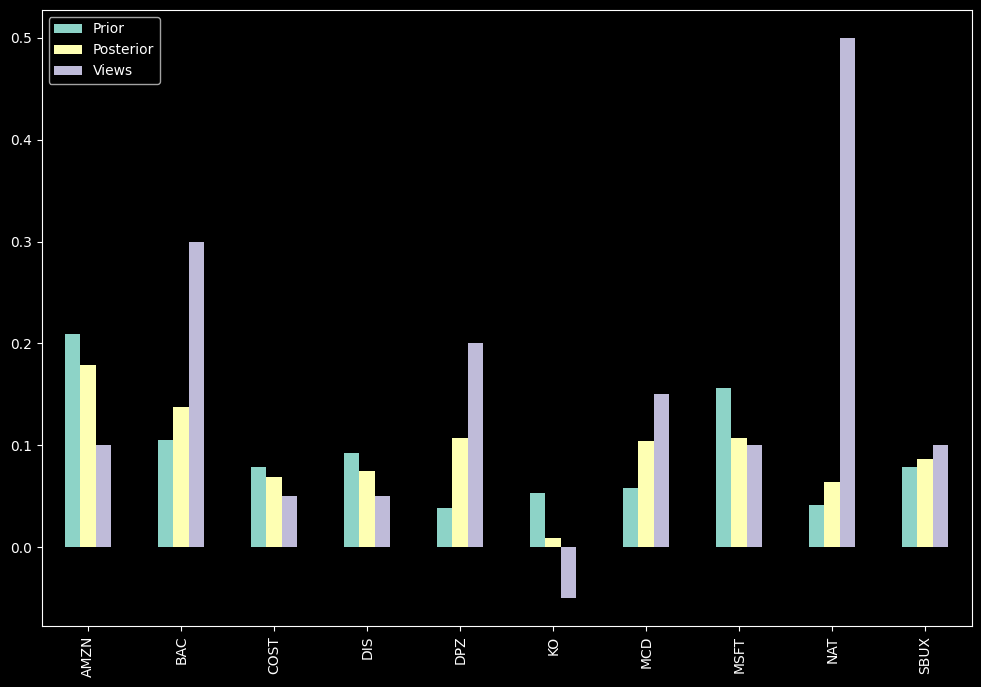

In [22]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

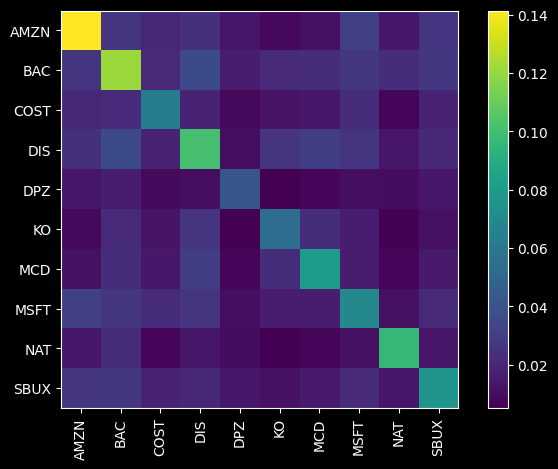

In [23]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [24]:
from pypfopt import EfficientFrontier, objective_functions

In [25]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/robert/Dev/PyPortfolioOpt/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.19488),
             ('BAC', 0.14496),
             ('COST', 0.07173),
             ('DIS', 0.07076),
             ('DPZ', 0.12771),
             ('KO', 0.0),
             ('MCD', 0.11622),
             ('MSFT', 0.11613),
             ('NAT', 0.0669),
             ('SBUX', 0.0907)])

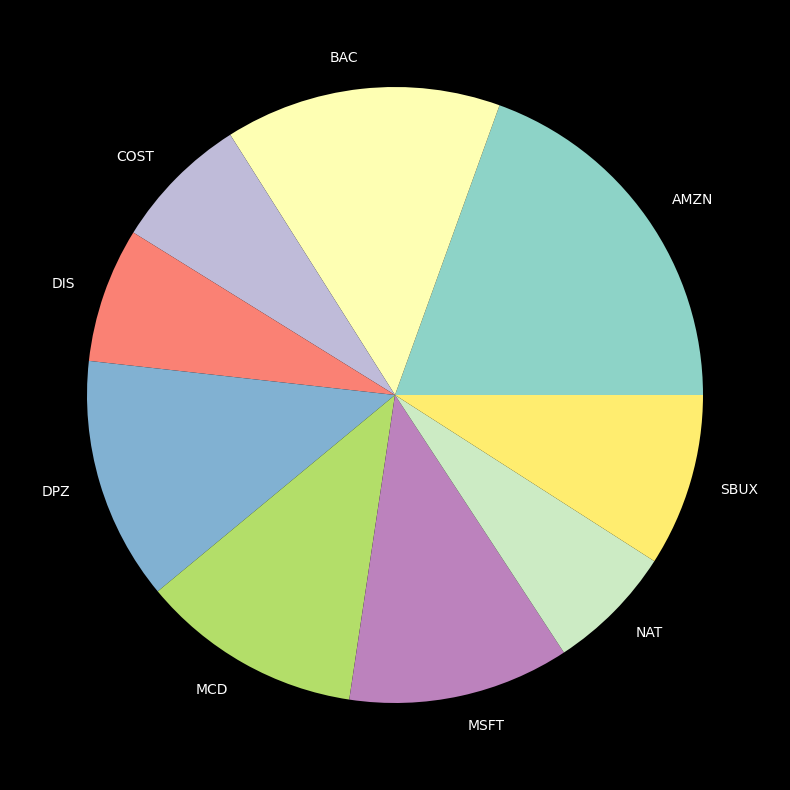

In [26]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [29]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $3.37


{'AMZN': np.int64(18),
 'BAC': np.int64(60),
 'COST': np.int64(2),
 'DIS': np.int64(12),
 'DPZ': np.int64(5),
 'MCD': np.int64(8),
 'MSFT': np.int64(5),
 'NAT': np.int64(500),
 'SBUX': np.int64(18)}